In [1]:
import leafcutter
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from leafcutter.differential_splicing import bb_glm
import pyro.distributions as dist

/home/david/venvs/raytune/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
total_count = 100
N = 8
P = 4
J = 1000
x_null,y,true_b,g = bb_glm.simple_simulation(
    N = N, P = P, J = J, total_count = total_count, conc = 20.)
n = torch.full( [N,J], total_count)
x = torch.concat([x_null,torch.randn(N,1)],1)
#x_null = x[:,:-1]

In [3]:
beta_init = bb_glm.fit_binomial_glm(x_null, y, n)
losses, guide, full_fit = bb_glm.svi_bb_glm(
    x_null, y, n, beta_init = beta_init, 
    beta_scale = dist.HalfCauchy(1.),
    concShape = dist.Gamma(2,0.2), 
    concRate = dist.InverseGamma(2,0.04))

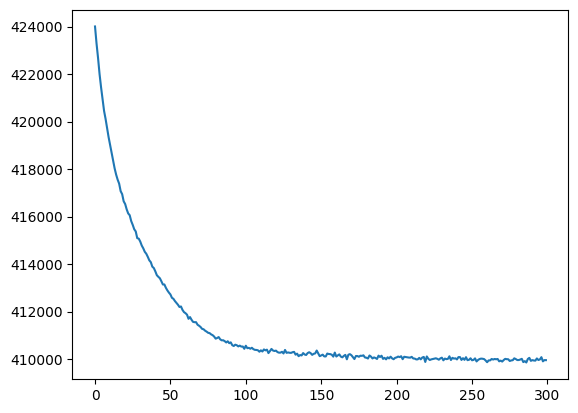

In [4]:
plt.plot(losses)

In [5]:
torch.corrcoef(torch.stack([full_fit.beta.flatten(), true_b.flatten()]))[0,1].item()

0.9235280752182007

In [6]:
guide.median()["gamma_shape"]

tensor(3.3965)

In [7]:
guide.median()["gamma_rate"]

tensor(0.1909)

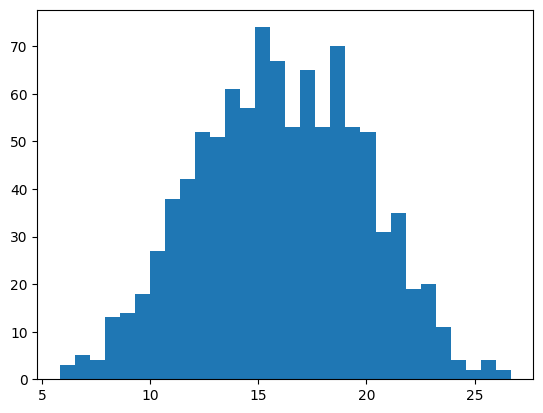

In [8]:
_ = plt.hist(full_fit.conc, 30)

/home/david/venvs/raytune/lib/python3.10/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'gamma_shape'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
/home/david/venvs/raytune/lib/python3.10/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'gamma_shape'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


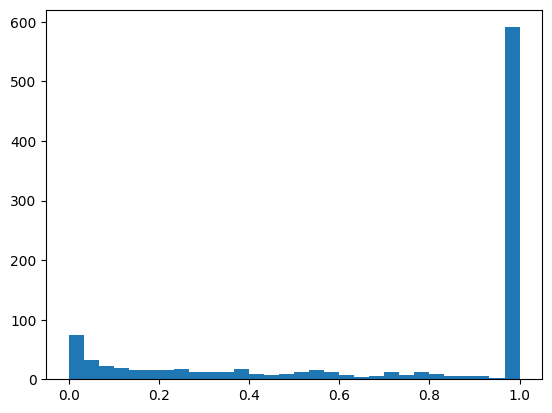

In [9]:
loglr, df, lrtp, null_fit, full_fit, refit_null_flag = bb_glm.beta_binomial_anova(
    x, x_null, y, n, concShape = dist.Gamma(2,0.2))

_ = plt.hist(lrtp,30)